# Optimal complexity finite element assembly

## Sum factorisation
Suppose we are assemblying the 2-form of the Laplace operator on a hexahedral element, e.g. the Q3 element:

<figure>
  <center><img src="image/Q3_hexahedron.png" alt="Q3" style="width: 400px;"/></center>
  <center><figcaption>$Q_3$ element on hexahedron. Image from <a href="http://femtable.org/">the periodic table.</a></figcaption></center>
</figure>

Since each quadrature point $X$ can be represented as a 3-tuple $q=\{q_1,q_2,q_3\}$, and each basis function by a 3-tuple $i = \{i_1,i_2,i_3\}$, the naive local assembly kernel for the local tensor $A_{ij}$ contains the loop structure:
```
for q1, q2, q3
  for i1, i2, i3
    for j1, j2, j3
      A[i1,i2,i3,j1,j2,j3] += ...
```
This requires $O(N_{q}^3N_{i}^6)$ FLOPs. For polynomial degree $p$, both $N_q$ and $N_i$ are $O(p)$, so this local assembly requires $O(p^9)$ FLOPs.

For *tensor product elements* like this, we can rearrange the contraction over quadrature points and hoist invariant sub-expressions out of the innermost loop into temporary variables. This is known as *sum factorisation*:
```
for q1, i1, j1
  t1[i1,j1] += ...
for q2, i2, j2
  t2[i2,j2] += ...
for q3
  for i1, i2, i3
    for j1, j2, j3
      A[i1,i2,i3,j1,j2,j3] += t1*t2*...
```
This reduces the complexity to $O(p^7)$.

TSFC \[1\], the form compiler of Firedrake, is capable of exploiting this intrinsic structure of the finite element, provided by FInAT \[2\], and apply sum factorisation automatically to generate assembly kernels with optimal algorithmic complexity.

In [1]:
%matplotlib notebook
from firedrake import *
set_log_level(ERROR)

We can create a hexahedral mesh by extruding a quadrilateral mesh.

In [2]:
mesh = ExtrudedMesh(UnitSquareMesh(10, 10, quadrilateral=True), 10)

Let's choose the continuous Lagrange element of degree 5 as our function space.

In [3]:
p = 5
V = FunctionSpace(mesh, "CG", p)
u = TrialFunction(V)
v = TestFunction(V)
a = dot(grad(u), grad(v)) *dx  # Laplace operator

Firedrake internalises the process of local assembly. In order to look at the kernel, we need to import the compilation interface from TSFC.

In [4]:
from tsfc import compile_form

TSFC organises the optimisation passes into *modes*. Let's first try the *vanilla* mode, which does as little optimisation as possible:

In [5]:
kernel_vanilla, = compile_form(a, parameters={"mode": "vanilla"})

The COFFEE package provides some useful tools to inspect the local assembly kernel, such as the FLOPs estimator.

In [6]:
from coffee.visitors import EstimateFlops
print("Local assembly FLOPs with vanilla mode is {0:.3g}".format(EstimateFlops().visit(kernel_vanilla.ast)))

Local assembly FLOPs with vanilla mode is 1.15e+08


The default optimisation mode in TSFC is *spectral*, which applies sum factorisation to determine the tensor contraction order, and at each level, apply *argument factorisation* \[3\] to rearrange the expression using associative and distributive laws. Since *spectral* is the default mode, we do not need to specify it in the parameters.

In [7]:
kernel_spectral, = compile_form(a)
print("Local assembly FLOPs with spectral mode is {0:.3g}".format(EstimateFlops().visit(kernel_spectral.ast)))

Local assembly FLOPs with spectral mode is 2.66e+06


This is a 34x reduction in FLOPs. Not bad, but there's opportunity to do better. For spectral elements, if we use the Gauss–Lobatto–Legendre (GLL) quadrature scheme, which has quadrature points collated with the Lagrange basis function nodes, then we know that the basis function tabulation is an indentity matrix. TSFC and FInAT can further simplify the loop structure of the local assembly kernels. This reduces the complexity to $O(p^5)$.

We need to specify the GLL quadrature scheme for hexahedra. We can do this with FIAT, which defines GLL on intervals, and FInAT, which makes the tensor product scheme from the interval scheme.

In [8]:
import FIAT, finat

def gauss_lobatto_legendre_line_rule(degree):
    fiat_make_rule = FIAT.quadrature.GaussLobattoLegendreQuadratureLineRule
    fiat_rule = fiat_make_rule(FIAT.ufc_simplex(1), degree + 1)
    finat_ps = finat.point_set.GaussLobattoLegendrePointSet
    finat_qr = finat.quadrature.QuadratureRule
    return finat_qr(finat_ps(fiat_rule.get_points()), fiat_rule.get_weights())

def gauss_lobatto_legendre_cube_rule(dimension, degree):
    make_tensor_rule = finat.quadrature.TensorProductQuadratureRule
    result = gauss_lobatto_legendre_line_rule(degree)
    for _ in range(1, dimension):
        line_rule = gauss_lobatto_legendre_line_rule(degree)
        result = make_tensor_rule([result, line_rule])
    return result

We start by creating the spectral finite element function space of the same polynomial degree.

In [9]:
element = FiniteElement('CG', mesh.ufl_cell(), degree=p, variant='spectral')
V = FunctionSpace(mesh, element)
u = TrialFunction(V)
v = TestFunction(V)

We need to tell Firedrake to use the GLL quadratures for numerical integration.

In [10]:
gll_quadrature_rule = gauss_lobatto_legendre_cube_rule(dimension=3, degree=p)
a_gll = dot(grad(u), grad(v)) *dx(rule=gll_quadrature_rule)

In [11]:
kernel_gll, = compile_form(a_gll)
print("Local assembly FLOPs with GLL quadrature is {0:.3g}".format(EstimateFlops().visit(kernel_gll.ast)))

Local assembly FLOPs with GLL quadrature is 2.21e+05


This is a further 10x reduction in FLOPs.

Now, let's verify that we achieve the expected asymptotic algorithmic complexity with respect to polynomial degrees.

In [12]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy

In [13]:
flops = defaultdict(list)
ps = range(1, 33)  # polynomial degrees
modes = {
    'gll': {'mode': 'spectral', 'variant': 'spectral', 'rule': gauss_lobatto_legendre_cube_rule},
    'spectral': {'mode': 'spectral', 'variant': None, 'rule': lambda *args: None},
    'vanilla': {'mode': 'vanilla', 'variant': None, 'rule': lambda *args: None}
}

for p in ps:
    for mode in modes:
        element = FiniteElement('CG', mesh.ufl_cell(), degree=p, variant=modes[mode]['variant'])
        V = FunctionSpace(mesh, element)
        u = TrialFunction(V)
        v = TestFunction(V)
        a = dot(grad(u), grad(v))*dx(rule=modes[mode]['rule'](3, p))
        kernel, = compile_form(a, parameters={"mode": modes[mode]['mode']})
        flops[mode].append(EstimateFlops().visit(kernel.ast))

<IPython.core.display.Javascript object>


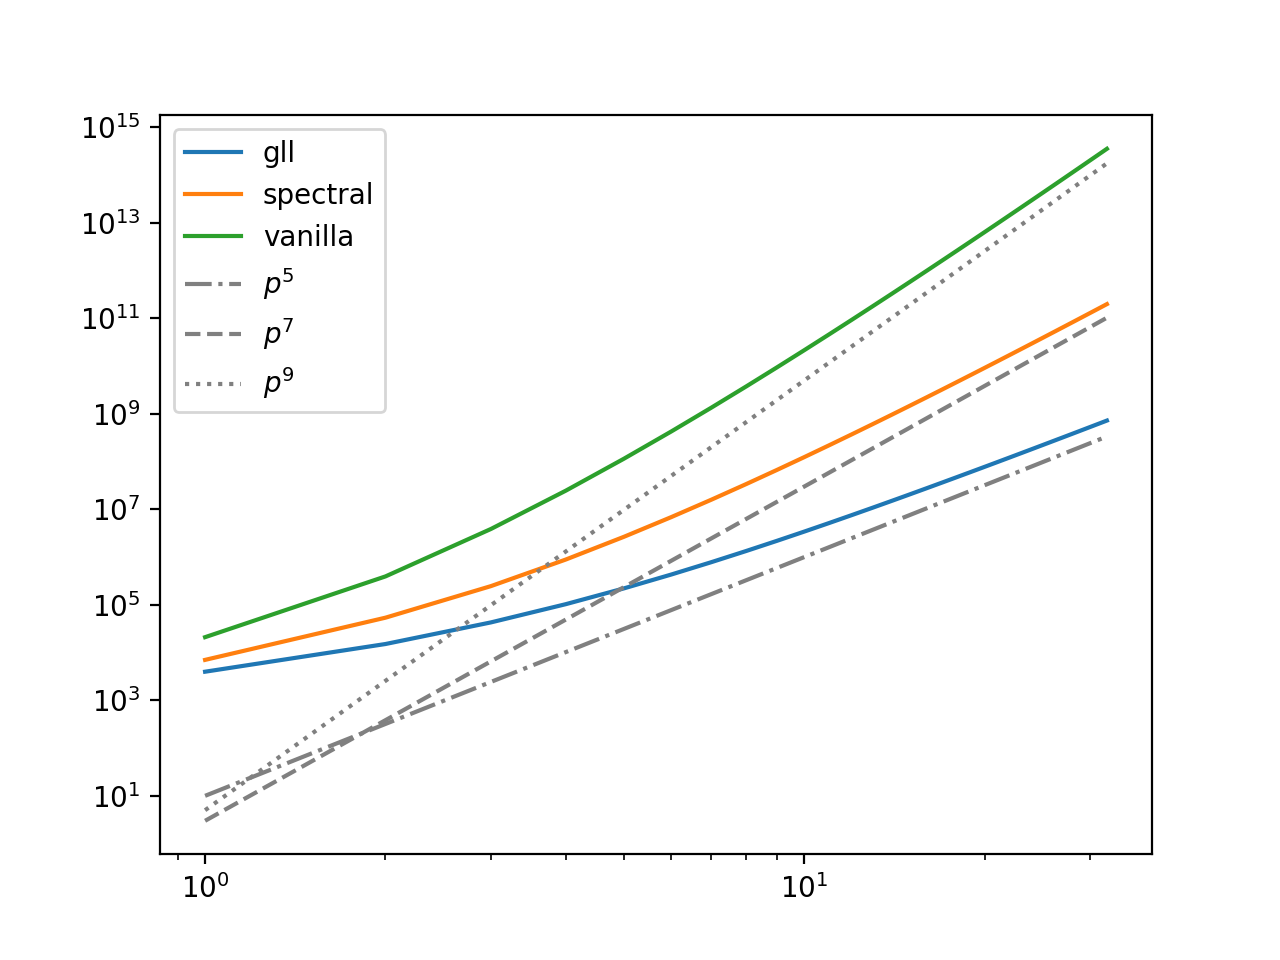

In [14]:
fig, ax = plt.subplots(1, 1)
ax.set_xscale('log')
ax.set_yscale('log')
for mode in modes:
    ax.plot(ps, flops[mode], label=mode)
x = numpy.linspace(1, 32, 100)
for p, style, offset in zip([5,7,9], ['-.','--',':'], [10, 3, 5]):
    ax.plot(x, numpy.power(x, p)*offset, label=r"$p^{0}$".format(p), color='grey', linestyle=style)
ax.legend(loc='upper left');

Finally, let's do the same analysis on a different problem:  $a (u,v) = \int_\Omega\left( \nabla\times u \right) \cdot \left( \nabla\times v \right)\,\text{d}x$, on the H(curl) conforming NCE element.

In [15]:
# This might take some time to run
flops_curl = defaultdict(list)
ps_curl = range(1, 17)
for p in ps_curl:
    for mode in modes:
        element = FiniteElement('NCE', mesh.ufl_cell(), degree=p, variant=modes[mode]['variant'])
        V = FunctionSpace(mesh, element)
        u = TrialFunction(V)
        v = TestFunction(V)
        a = dot(curl(u), curl(v))*dx(rule=modes[mode]['rule'](3, p))
        kernel, = compile_form(a, parameters={"mode": modes[mode]['mode']})
        flops_curl[mode].append(EstimateFlops().visit(kernel.ast))

<IPython.core.display.Javascript object>


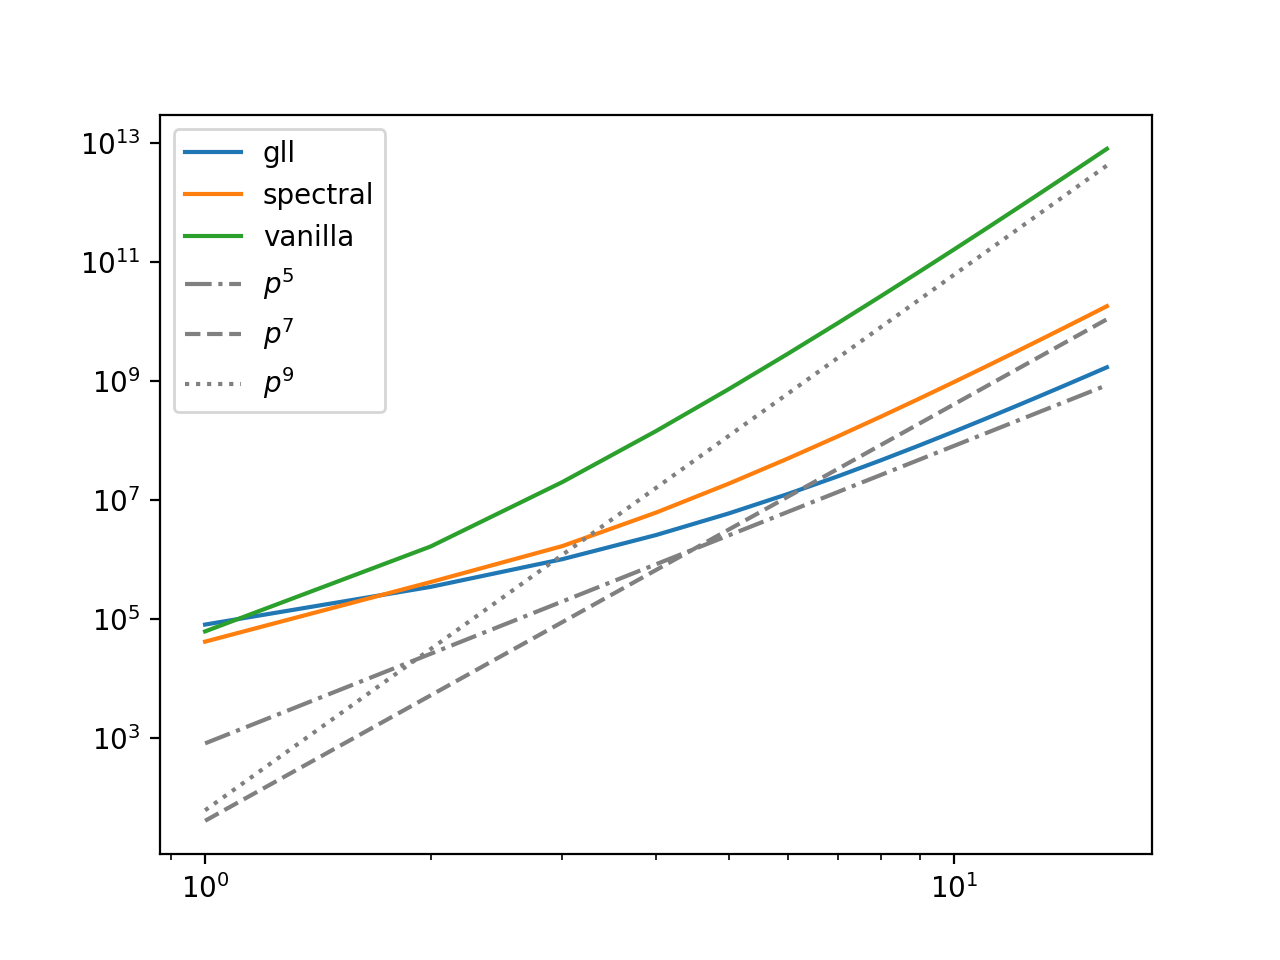

In [16]:
fig, ax = plt.subplots(1, 1)
ax.set_xscale('log')
ax.set_yscale('log')
for mode in modes:
    ax.plot(ps_curl, flops_curl[mode], label=mode)
x = numpy.linspace(1, 16, 100)
for p, style, offset in zip([5,7,9], ['-.','--',':'], [800,40,60]):
    ax.plot(x, numpy.power(x, p)*offset, label=r"$p^{0}$".format(p), color='grey', linestyle=style)
ax.legend(loc='upper left');

## References
\[1\] Homolya, M., Mitchell, L., Luporini, F. and Ham, D.A., 2018. TSFC: a structure-preserving form compiler. SIAM Journal on Scientific Computing, 40(3), pp.C401-C428.

\[2\] Homolya, M., Kirby, R.C. and Ham, D.A., 2017. Exposing and exploiting structure: optimal code generation for high-order finite element methods. arXiv preprint arXiv:1711.02473.

\[3\] Luporini, F., Ham, D.A. and Kelly, P.H., 2017. An algorithm for the optimization of finite element integration loops. ACM Transactions on Mathematical Software (TOMS), 44(1), p.3.